# Uncertainty Aware Road Obstacle Identification (UAROI)

---

**Final Project and Exam $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ Computer Vision | Sapienza Università di Roma**

---

* Jose Edgar Hernandez Cancino Estrada | 2223606  
* Marcelo Jimenez Da Fonseca | 2224588  
* Enrique Favila Martinez | 2223610

## Sigmoid-Head Classification Model using CityScapes Data

---



**References**

- Sakaridis, C., Dai, D., & Van Gool, L. (2019). *Road Obstacle Detection based on Unknown Objectness Scores*. [https://arxiv.org/abs/1905.07477](https://arxiv.org/abs/1905.07477)

- Cordts, M., Omran, M., Ramos, S., Rehfeld, T., Enzweiler, M., Benenson, R., ... & Schiele, B. (2016). *The Cityscapes Dataset for Semantic Urban Scene Understanding*. [https://www.cityscapes-dataset.com](https://www.cityscapes-dataset.com)

# 1. Imports

In [ ]:
import re
import os
import gc
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import pathlib, shutil, zipfile

from PIL import Image
from tqdm import tqdm
from random import sample
from itertools import islice
from IPython.display import display, clear_output

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torch.amp import GradScaler, autocast
from torchvision.datasets import Cityscapes
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

# 2. Globals

In [ ]:
# Global variables
# DATASET_PATH = r"/content/drive/MyDrive/datasets/cityscapes"
LOCAL_PATH = "/content/dataset"

# Select the best available device (CPU, CUDA, or MPS (Metal Performance Shaders for macOS))
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Metal Performance Shaders) device")
else:
    device = torch.device("cpu")
    print("Using CPU")
DEVICE = device

Using CUDA device: NVIDIA A100-SXM4-40GB


# 3. Utils

### General

In [ ]:
def unzip(zip_path, dest):
    zip_path = pathlib.Path(zip_path)
    dest = pathlib.Path(dest)
    print(f"Extracting {zip_path.name} ...")
    with zipfile.ZipFile(zip_path, 'r') as z:
        # Get the list of files in the zip for the progress bar
        file_list = z.namelist()
        # Use tqdm to wrap the iteration over the file list
        for file in tqdm(file_list, desc=f"Extracting {zip_path.name}", unit="file"):
            # Extract each file individually
            z.extract(file, dest)
    print("done!")

def get_boundary_mask(mask, dilation_ratio=0.0075):
    """
    Get boundary map using morphological gradient.
    Input:  mask [B, C, H, W] binary ground truth masks for each class
    Output: boundary_map [B, C, H, W]
    """
    boundaries = []

    for i in range(mask.shape[0]):
        boundary_per_image = []
        for c in range(mask.shape[1]):
            # Convert to numpy
            mask_np = mask[i, c].cpu().numpy().astype(np.uint8)
            h, w = mask_np.shape
            kernel_size = max(1, int(round(dilation_ratio * (h + w) / 2)))
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

            # Morphological gradient: dilation - erosion
            dilated = cv2.dilate(mask_np, kernel)
            eroded = cv2.erode(mask_np, kernel)
            boundary = dilated - eroded

            boundary_per_image.append(torch.tensor(boundary, dtype=torch.float32))
        boundaries.append(torch.stack(boundary_per_image))
    return torch.stack(boundaries).to(mask.device)  # [B, C, H, W]

### Cityscapes utils

In [ ]:
# 0 Is Road
# 1 Is Flat Non-Road
# 2 Is Construction
# 3 Is Object
# 4 Is Background
# 5 Is Human
# 6 Is Vehicle
# 7 Is OOD Object
# 255 Is No Class

ID_TO_CLASS = {
     0: 255,  #  0 Unlabeled            -> 255  void
     1: 255,  #  1 Ego vehicle          -> 255  void
     2: 255,  #  2 Rectification border -> 255  void
     3: 255,  #  3 Out of roi           -> 255  void

     4:   7,  #  4 Static               -> 7    OOD Object          -- Objectness
     5:   7,  #  5 Dynamic              -> 7    OOD Object          -- Objectness
     6: 255,  #  6 Ground               -> 7    void

     7:   0,  #  7 Road                 -> 0    Road

     8:   1,  #  8 Sidewalk             -> 1    Flat non-road
     9:   1,  #  9 Parking              -> 1    Flat non-road
    10:   1,  # 10 Rail track           -> 1    Flat non-road

    11:   2,  # 11 Building             -> 2    Construction        -- Objectness
    12:   2,  # 12 Wall                 -> 2    Construction        -- Objectness
    13:   2,  # 13 Fence                -> 2    Construction        -- Objectness
    14:   2,  # 14 Guard rail           -> 2    Construction        -- Objectness
    15:   2,  # 15 Bridge               -> 2    Construction        -- Objectness
    16:   2,  # 16 Tunnel               -> 2    Construction        -- Objectness

    17:   3,  # 17 Pole                 -> 3    Object              -- Objectness
    18:   3,  # 18 Polegroup            -> 3    Object              -- Objectness
    19:   3,  # 19 Traffic light        -> 3    Object              -- Objectness
    20:   3,  # 20 Traffic sign         -> 3    Object              -- Objectness

    21:   4,  # 21 Vegetation           -> 4    Background
    22:   4,  # 22 Terrain              -> 4    Background
    23:   4,  # 23 Sky                  -> 4    Background

    24:   5,  # 24 Person               -> 5    Human               -- Objectness
    25:   5,  # 25 Rider                -> 5    Human               -- Objectness

    26:   6,  # 26 Car                  -> 6    Vehicle             -- Objectness
    27:   6,  # 27 Truck                -> 6    Vehicle             -- Objectness
    28:   6,  # 28 Bus                  -> 6    Vehicle             -- Objectness
    29:   6,  # 29 Caravan              -> 6    Vehicle             -- Objectness
    30:   6,  # 30 Trailer              -> 6    Vehicle             -- Objectness
    31:   6,  # 31 Train                -> 6    Vehicle             -- Objectness
    32:   6,  # 32 Motorcycle           -> 6    Vehicle             -- Objectness
    33:   6   # 33 Bicycle              -> 6    Vehicle             -- Objectness
}


def group_classes(pil_img):
    id_mask = np.array(pil_img, dtype=np.uint8)
    train_id_mask = np.full_like(id_mask, 255)  # default to ignore

    for cityscapes_id, new_class_id in ID_TO_CLASS.items():
        train_id_mask[id_mask == cityscapes_id] = new_class_id

    return train_id_mask


CITYSCAPES_GROUPS = {
    'road':         0,            # road
    'flat_nonroad': 1,            # sidewalk
    'construction': 2,            # building, wall, fence               - Obj
    'object':       3,            # pole, traffic light, traffic sign   - Obj
    'background':   4,            # vegetation, terrain, sky
    'human':        5,            # person, rider                       - Obj
    'vehicle':      6,            # car to bicycle                      - Obj
    'ood_object':   7             # OOD object                          - Obj
}

GROUP_NAMES = ['Road', 'Flat(non-road)', 'Construction', 'Object', 'Background', 'Human', 'Vehicle', 'Objectness']
OBJECTNESS_GROUP = [2, 3, 5, 6, 7]
NUM_GROUPS = 7  # Last group (index 7) = Objectness


# -------------------------
# Label Conversion Function
# -------------------------

def convert_mask_to_multilabel(pil_img):
    mask_np = np.array(pil_img, dtype=np.uint8)  # trainId mask
    H, W = mask_np.shape
    label_tensor = np.zeros((NUM_GROUPS + 1, H, W), dtype=np.float32)  # [C, H, W]

    for group_id in range(NUM_GROUPS):
        mask = (mask_np == group_id)
        label_tensor[group_id][mask] = 1.0 # Must match group_id and position in tensor

        if group_id in OBJECTNESS_GROUP:
            label_tensor[NUM_GROUPS][mask] = 1.0  # Set objectness channel

    # Include OOD_object class (last class)
    label_tensor[NUM_GROUPS][mask_np == 7] = 1.0

    return torch.from_numpy(label_tensor)

# -------------------------
# Transforms and Dataset
# -------------------------

img_tf = transforms.ToTensor()
lbl_tf = transforms.Lambda(lambda img: convert_mask_to_multilabel(Image.fromarray(group_classes(img))))


### Visualization

In [ ]:
# -------------------------
# Visualization
# -------------------------

def visualize_sample(dataset, index=4):
    image, mask = dataset[index]
    print("----------------------------------")
    print(f"Image shape: {image.shape}")
    print(f"Mask shape: {mask.shape}")

    for i, group_name in enumerate(GROUP_NAMES):
        pixel_count = mask[i].sum().item()
        total_pixels = mask[i].numel()
        percentage = (pixel_count / total_pixels) * 100
        print(f"{group_name}: {pixel_count:.0f} pixels ({percentage:.2f}%)")
    print("----------------------------------")
    visualize_multilabel_mask(image, mask)

def visualize_multilabel_mask(image, multilabel_mask, save_path=None):
    COLORS = plt.cm.tab10.colors
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()

    img_np = image.permute(1, 2, 0).cpu().numpy()
    axes[0].imshow(img_np)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    for i in range(8):
        mask = multilabel_mask[i].cpu().numpy()
        overlay = np.zeros_like(img_np)
        color = COLORS[i % len(COLORS)]
        for c in range(3):
            overlay[..., c] = mask * color[c]
        blended = 0.5 * img_np + 0.5 * overlay
        axes[i + 1].imshow(blended)
        axes[i + 1].set_title(f'{GROUP_NAMES[i]} (sum={mask.sum():.0f})')
        axes[i + 1].axis('off')

    if len(axes) > 8:
        axes[8].axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

def visualize_boundaries(image, mask):
    fig, axes = plt.subplots(1, 2, figsize=(15, 12))
    axes = axes.flatten()
    img_np = image.permute(1, 2, 0).cpu().numpy()
    axes[0].imshow(img_np)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    axes[1].imshow(mask.cpu().numpy(), cmap='gray')
    axes[1].set_title('Boundary Mask')
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()


def visualize_uos(image, multilabel_mask, unkown_obj_score, unknown_score, objectness_score):
    import matplotlib.pyplot as plt
    import numpy as np

    COLORS = plt.cm.tab10.colors  # 10 distinct colors
    image_np = image.permute(1, 2, 0).cpu().numpy()
    uos_np = unkown_obj_score.cpu().numpy()
    unknown_class_score_np = unknown_score.cpu().numpy()
    objectness_score_np = objectness_score.cpu().numpy()

    fig, axs = plt.subplots(1, 4, figsize=(22, 6))
    titles = [
        "Segmentation Mask",
        "Objectness Class Prediction",
        "Unknown Class Score",
        "Unknown Object Score"
    ]

    # ---------------------------
    # 1. Multi-label mask overlay
    # ---------------------------
    overlay = np.zeros_like(image_np)
    mask_sum = np.zeros_like(multilabel_mask[0].cpu().numpy())

    for i in range(multilabel_mask.shape[0]):
        mask_i = multilabel_mask[i].cpu().numpy()
        if np.sum(mask_i) == 0:
            continue  # Skip empty class masks
        color = COLORS[i % len(COLORS)]
        for c in range(3):
            overlay[..., c] += (mask_i > 0) * color[c]
        mask_sum += (mask_i > 0)

    # Normalize so no pixel exceeds 1.0
    mask_sum = np.clip(mask_sum, 1, None)  # avoid divide-by-zero
    overlay /= mask_sum[..., None]
    blended = 0.5 * image_np + 0.5 * overlay
    blended = np.clip(blended, 0, 1)

    axs[0].imshow(blended)
    axs[0].set_title(titles[0], fontsize=16)
    axs[0].axis("off")

    # ---------------------------
    # 2. Objectness Score
    # ---------------------------
    axs[1].imshow(image_np * 0.8)
    axs[1].imshow(objectness_score_np, alpha=0.65, cmap='plasma')
    axs[1].set_title(titles[1], fontsize=16)
    axs[1].axis("off")

    # ---------------------------
    # 3. Unknown Class Score
    # ---------------------------
    axs[2].imshow(image_np * 0.8)
    im_unk_class = axs[2].imshow(unknown_class_score_np, cmap='hot', alpha=0.8)
    axs[2].set_title(titles[2], fontsize=16)
    axs[2].axis("off")
    cbar1 = fig.colorbar(im_unk_class, ax=axs[2], fraction=0.046, pad=0.02)
    cbar1.ax.tick_params(labelsize=10)

    # ---------------------------
    # 4. Unknown Object Score
    # ---------------------------
    axs[3].imshow(image_np * 0.8)
    im_uos = axs[3].imshow(uos_np, cmap='hot', alpha=0.8)
    axs[3].set_title(titles[3], fontsize=16)
    axs[3].axis("off")
    cbar2 = fig.colorbar(im_uos, ax=axs[3], fraction=0.046, pad=0.02)
    cbar2.ax.tick_params(labelsize=10)

    plt.tight_layout()
    plt.show()

# 4. Data
Load and preprocess datasets like Cityscapes, LostAndFound, and Fishyscapes.

### Load into VM

In [ ]:
# !pip install --upgrade gdown
!gdown --folder https://drive.google.com/drive/folders/1gGUf_j6n45k_HrgIhhYdbLyQ1eI_XeNb -O dataset

# Unzip
urls = ['/content/dataset/leftImg8bit_trainvaltest.zip', '/content/dataset/gtFine_trainvaltest.zip']
for url in urls:
    zippath = pathlib.Path(url)
    DEST_PATH = pathlib.Path("/content/dataset")
    unzip(zippath, DEST_PATH)
    zippath.unlink()
    print("ZIP files extracted and deleted")

Retrieving folder contents
Processing file 1MmuK0PGklYrp0MzpeCU6gJ_ZuU9MptvT gtFine_trainvaltest.zip
Processing file 1iOa8PgSKf_rXkQfE4YpwEdIimeGfsACU leftImg8bit_trainvaltest.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1MmuK0PGklYrp0MzpeCU6gJ_ZuU9MptvT
From (redirected): https://drive.google.com/uc?id=1MmuK0PGklYrp0MzpeCU6gJ_ZuU9MptvT&confirm=t&uuid=44f862c9-40c4-446a-ba94-d6b6a773c552
To: /content/dataset/gtFine_trainvaltest.zip
100% 253M/253M [00:05<00:00, 43.9MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1iOa8PgSKf_rXkQfE4YpwEdIimeGfsACU
From (redirected): https://drive.google.com/uc?id=1iOa8PgSKf_rXkQfE4YpwEdIimeGfsACU&confirm=t&uuid=239072f7-d9c6-4431-81e0-18977091e80a
To: /content/dataset/leftImg8bit_trainvaltest.zip
100% 11.6G/11.6G [03:30<00:00, 55.1MB/s]
Download completed
Extracting leftImg8bit_trainvaltest.zip ...


Extracting leftImg8bit_trainvaltest.zip: 100%|██████████| 5032/5032 [00:36<00:00, 139.63file/s]


done!
ZIP files extracted and deleted
Extracting gtFine_trainvaltest.zip ...


Extracting gtFine_trainvaltest.zip: 100%|██████████| 20032/20032 [00:05<00:00, 3602.82file/s]

done!
ZIP files extracted and deleted


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Dataset

In [ ]:
train_set = Cityscapes(root=LOCAL_PATH, split='train', mode='fine', target_type='semantic', transform=img_tf, target_transform=lbl_tf)
val_set = Cityscapes(root=LOCAL_PATH, split = 'val', mode='fine', target_type ='semantic', transform=img_tf, target_transform=lbl_tf)
test_set = Cityscapes(root=LOCAL_PATH, split='test', mode='fine', target_type='semantic', transform=img_tf, target_transform=None)

print(f"Train set size: {len(train_set)}")
print(f"Train set >>label<< shape: {train_set[0][1].shape}", end="\n\n")

print(f"Validation set size: {len(val_set)}")
print(f"Validation set >>label<< shape: {val_set[0][1].shape}", end="\n\n")

print(f"Test set size: {len(test_set)}")
print(f"Test set >>item<< shape: {test_set[0][0].shape}")

Train set size: 2975
Train set >>label<< shape: torch.Size([8, 1024, 2048])

Validation set size: 500
Validation set >>label<< shape: torch.Size([8, 1024, 2048])

Test set size: 1525
Test set >>item<< shape: torch.Size([3, 1024, 2048])


# 5. Unknown Road Obstacle Identification Network



### Sigmoid-Head classification model architecture (DeepLabV3 Backbone)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import os

class DeepLabV3_SigmoidHead(nn.Module):
    def __init__(self, num_classes, weights_path=None):
        super().__init__()
        self.num_classes = num_classes

        if weights_path and os.path.exists(weights_path):
            backbone = deeplabv3_resnet50(weights=None)
        else:
            backbone = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)

        self.backbone_features = backbone.backbone
        self.aspp = backbone.classifier[0]
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Conv2d(256, num_classes + 1, kernel_size=1)
        )

        if weights_path:
            self.load_weights(weights_path)

    def forward(self, x):
        input_shape = x.shape[-2:]
        features = self.backbone_features(x)
        x = self.aspp(features['out'])
        x = self.classifier(x)
        x = F.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)
        return x

    def load_weights(self, path):
        if not os.path.exists(path):
            print("No model weights found at:", path)
            return
        state_dict = torch.load(path, map_location='cpu')
        self.load_state_dict(state_dict)
        print(f"Loaded model weights from {path}")

    def save_weights(self, path):
        dir_path = os.path.dirname(path)
        if dir_path:
            os.makedirs(dir_path, exist_ok=True)
        torch.save(self.state_dict(), path)
        print(f"Model weights saved to {path}")

    def save_checkpoint(self, optimizer, scheduler, scaler, epoch, path='checkpoints/last_checkpoint.pth'):
        os.makedirs(os.path.dirname(path), exist_ok=True)
        torch.save({
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'scaler_state_dict': scaler.state_dict(),
            'epoch': epoch
        }, path)
        print(f"Checkpoint saved at epoch {epoch} to {path}")

    def load_checkpoint(self, optimizer, scheduler, scaler, path='checkpoints/last_checkpoint.pth'):
        if not os.path.exists(path):
            print("No checkpoint found at:", path)
            return 0
        checkpoint = torch.load(path, map_location='cpu')
        self.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        scaler.load_state_dict(checkpoint['scaler_state_dict'])
        print(f"Loaded checkpoint from {path} (epoch {checkpoint['epoch']})")
        return checkpoint['epoch']

    @torch.no_grad()
    def evaluate_model(self, dataloader, loss_fn, device='cuda', training=True):
        self.eval()
        total_loss = 0.0
        correct = 0
        total_pixels = 0

        loop = tqdm(dataloader, desc="Evaluating", leave=False)

        for images, targets in loop:
            images = images.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)

            if training:
                with autocast():
                    outputs = self(images)
                    loss = loss_fn(outputs, targets)
            else:
                outputs = self(images)
                loss = loss_fn(outputs, targets)

            total_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == targets).float().sum().item()
            total_pixels += torch.numel(targets)

            del images, targets, outputs, preds, loss
            loop.set_postfix(loss=total_loss / (loop.n + 1), acc=correct / total_pixels)

        avg_loss = total_loss / len(dataloader)
        accuracy = correct / total_pixels
        return avg_loss, accuracy

    def unknown_obj_scores(self, image, uos_only=True):
        self.eval()
        with torch.no_grad():
            input_tensor = image.unsqueeze(0)  # [1,3,H,W]
            output = self(input_tensor)       # [1,num_classes+1,H,W]
            pred_mask = torch.sigmoid(output).squeeze(0).cpu()  # [num_classes+1,H,W]
            known_class_probs = pred_mask[:self.num_classes, :, :]  # [C, H, W]
            inv_known_class_probs = 1 - known_class_probs
            unknown_score = torch.prod(inv_known_class_probs, dim=0)  # [H, W]
            objectness_score = pred_mask[self.num_classes, :, :]  # last channel
            unknown_obj_score = unknown_score * objectness_score  # [H, W]

            if uos_only:
                return unknown_obj_score
            else:
                return unknown_obj_score, unknown_score, objectness_score, pred_mask

### Boundary-Aware Loss function

As proposed in the paper *"Road Obstacle Detection based on Unknown Objectness Scores"* by Sakaridis et al., the **boundary-aware loss function** is defined as:

$
\mathcal{L}_n = -\frac{1}{N} \sum_{i=1}^{N} \sum_{k \in \mathcal{C}} f(y_{ik}, p_{ik}) - \frac{\lambda}{\sum_i \delta_i} \sum_{i=1}^{N} \delta_i \sum_{k \in \mathcal{C}} f(y_{ik}, p_{ik}),
$

where:

- $f(y_{ik}, p_{ik})$ is the binary cross-entropy loss between ground truth label$ y_{ik} $ and prediction $ p_{ik} $,
- $\delta_i$ is an indicator whether pixel \( i \) lies on a class boundary,
- $\lambda$ controls the relative importance of the boundary-aware term,
- $\mathcal{C}$ is the set of classes,
- $N$ is the total number of pixels.

The second term places more weight on classification performance near object boundaries, encouraging sharper and more precise segmentation contours.

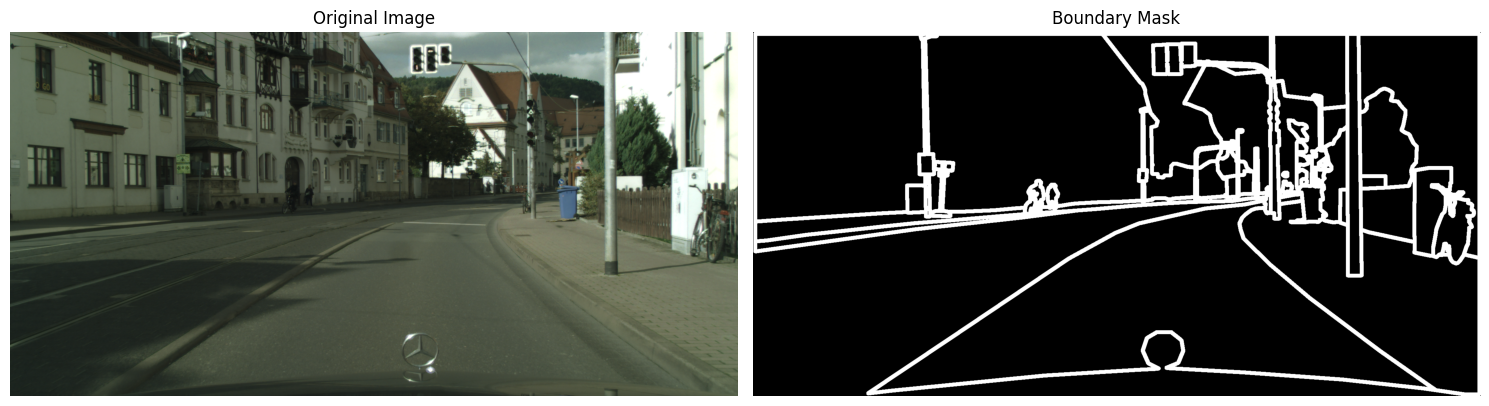

In [ ]:
# Example: visualizing boundaries for a sample
image, target = train_set[3]  # image: [3, H, W], target: [C, H, W]
# Batch dimension for boundary computation
target_batched = target.unsqueeze(0)  # [1, C, H, W]
# Get boundary mask
boundary_mask = get_boundary_mask(target_batched, dilation_ratio=0.0075)  # [1, C, H, W]
# Collapse across classes if needed (OR or MAX across channels)
boundary_mask_combined = boundary_mask[0].max(dim=0).values  # [H, W]
visualize_boundaries(image, boundary_mask_combined)

In [ ]:
def boundary_aware_bce_loss(pred_logits, target, lambda_weight=3.0, dilation_ratio=0.0075):
    bce = F.binary_cross_entropy_with_logits(pred_logits, target, reduction='none')

    # Term 1: standard BCE
    standard_loss = bce.sum() / torch.numel(bce)

    # Term 2: boundary-weighted BCE
    delta_i = get_boundary_mask(target, dilation_ratio=dilation_ratio)
    boundary_sum = delta_i.sum()

    if boundary_sum > 0:
        boundary_loss = (bce * delta_i).sum() / (boundary_sum + 1e-6)
        total_loss = standard_loss + lambda_weight * boundary_loss
    else:
        total_loss = standard_loss

    return total_loss

# 6. Training

### Model and objects definition

In [114]:
""" MODEL DEFINITION
  Create model for Cityscapes with 7 grouped classes + objectness
  As mentioned in the paper:
  1. "road"
  2. "flat(w/o road)"
  3. "human"
  4. "vehicle"
  5. "construction"
  6. "object"
  7. "background"
"""

# Training parameters
LEARNING_RATE = 0.01
EPOCHS = 15
BATCH_SIZE = 3

# Boundary-Aware loss parameters
boundary_dilation_ratio = 0.0075
lambda_weight = 3.0

# Previous model weights
model_weights   = '/content/drive/MyDrive/epoch_8_boundary_aware.pth'

model = DeepLabV3_SigmoidHead(num_classes=7, weights_path=model_weights)
loss_fn = lambda pred, target: boundary_aware_bce_loss(pred, target, lambda_weight=lambda_weight, dilation_ratio=boundary_dilation_ratio)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=True, num_workers=2, pin_memory=True)

# ====== Create a small validation subset loader ======
VAL_SUBSET_BATCHES = 6
BATCH_SIZE = int(val_loader.batch_size)
TOTAL_VAL_SAMPLES = VAL_SUBSET_BATCHES * BATCH_SIZE

val_indices = sample(range(len(val_set)), TOTAL_VAL_SAMPLES)
val_subset = Subset(val_set, val_indices)

val_subset_loader = torch.utils.data.DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'

Loaded model weights from /content/drive/MyDrive/epoch_8_boundary_aware.pth


### Training

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, loss_fn, scheduler,
                num_epochs=8, device='cuda', accumulation_steps=4, plot_loss=False):

    model.to(device)
    torch.cuda.empty_cache(); gc.collect()

    scaler = GradScaler()
    start_epoch = model.load_checkpoint(optimizer, scheduler, scaler)
    best_val_loss = float('inf')

    raw_loss_history = []
    avg_loss_history = []
    raw_acc_history = []
    avg_acc_history = []

    val_acc_history = []
    val_acc_positions = []
    val_loss_history = []
    val_loss_positions = []

    val_x_positions = []

    global_running_loss = 0.0
    global_running_acc = 0.0
    global_total_batches = 0

    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        running_correct = 0
        total_pixels = 0

        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
        optimizer.zero_grad()

        for batch_idx, (images, targets) in enumerate(loop):
            images = images.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            with autocast(enabled=(device == 'cuda')):
                outputs = model(images)
                original_loss = loss_fn(outputs, targets)
                scaled_loss = original_loss / accumulation_steps

            scaler.scale(scaled_loss).backward()

            with torch.no_grad():
                preds = (torch.sigmoid(outputs) > 0.5).float()
                # running_correct += (preds == targets).float().sum().item()
                # total_pixels += torch.numel(targets)

                batch_correct = (preds == targets).float().sum().item()
                batch_total = preds.numel()
                batch_acc = batch_correct / batch_total

                running_correct += batch_correct
                total_pixels += batch_total


            # Apped losses
            running_loss += original_loss.item()
            raw_loss_history.append(original_loss.item())

            global_running_loss += original_loss.item()
            global_total_batches += 1
            avg_loss_history.append(global_running_loss / global_total_batches)

            # Append accuracy
            raw_acc_history.append(batch_acc)
            global_running_acc += batch_acc
            avg_acc_history.append(global_running_acc / global_total_batches)

            if (batch_idx + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            del images, targets, outputs, preds, original_loss, scaled_loss
            if batch_idx % 5 == 0:
                torch.cuda.empty_cache(); gc.collect()

            loop.set_postfix(loss=running_loss / (batch_idx + 1))

            if plot_loss and batch_idx and batch_idx % 5 == 0:
                clear_output(wait=True)
                plt.figure(figsize=(20, 8))

                # LOSS
                plt.subplot(1, 2, 1)
                plt.plot(raw_loss_history, alpha=0.3, label="Raw Batch Loss")
                plt.plot(avg_loss_history, label="Global Avg Loss")
                if val_loss_history:
                    plt.scatter(val_x_positions, val_loss_history, label="Val Loss", color='red', zorder=5)

                plt.xlabel("Global Batch #")
                plt.ylabel("Loss")
                plt.title(f"Epoch {epoch+1}")
                plt.grid(True); plt.legend();

                # ACC
                plt.subplot(1, 2, 2)
                plt.plot(raw_acc_history, label="Raw Batch Accuracy", alpha=0.7)
                plt.plot(avg_acc_history, label="Global Avg Acc")
                if val_acc_history:
                    plt.scatter(val_x_positions, val_acc_history, label="Val Accuracy", color='green', zorder=5)

                plt.xlabel("Global Batch #")
                plt.ylabel("Accuracy")
                plt.title("Training Accuracy & Validation Accuracy")
                plt.grid(True); plt.legend()

                plt.tight_layout()
                plt.show()


        if (batch_idx + 1) % accumulation_steps != 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        train_loss = running_loss / len(train_loader)
        train_acc = running_correct / total_pixels
        print(f"Epoch {epoch+1} Summary:\nTrain Loss={train_loss:.4f}, Acc={train_acc:.4f}")


        print("Running Validation...")
        val_loss, val_acc = model.evaluate_model(val_loader, loss_fn, device)
        print(f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            model.save_weights("best_model.pth")
            print("New best model saved.")


        # Store current validation information for plotting
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        val_x_positions.append(global_total_batches)


        model.save_checkpoint(optimizer, scheduler, scaler, epoch+1)
        torch.save(model.state_dict(), f'checkpoints/epoch_{epoch+1}.pth')
        torch.cuda.empty_cache(); gc.collect()

    print("Training Complete.")



Training starting from a previous model's weights (8 epochs) dict for 5 more epochs to try to find any possible further learning

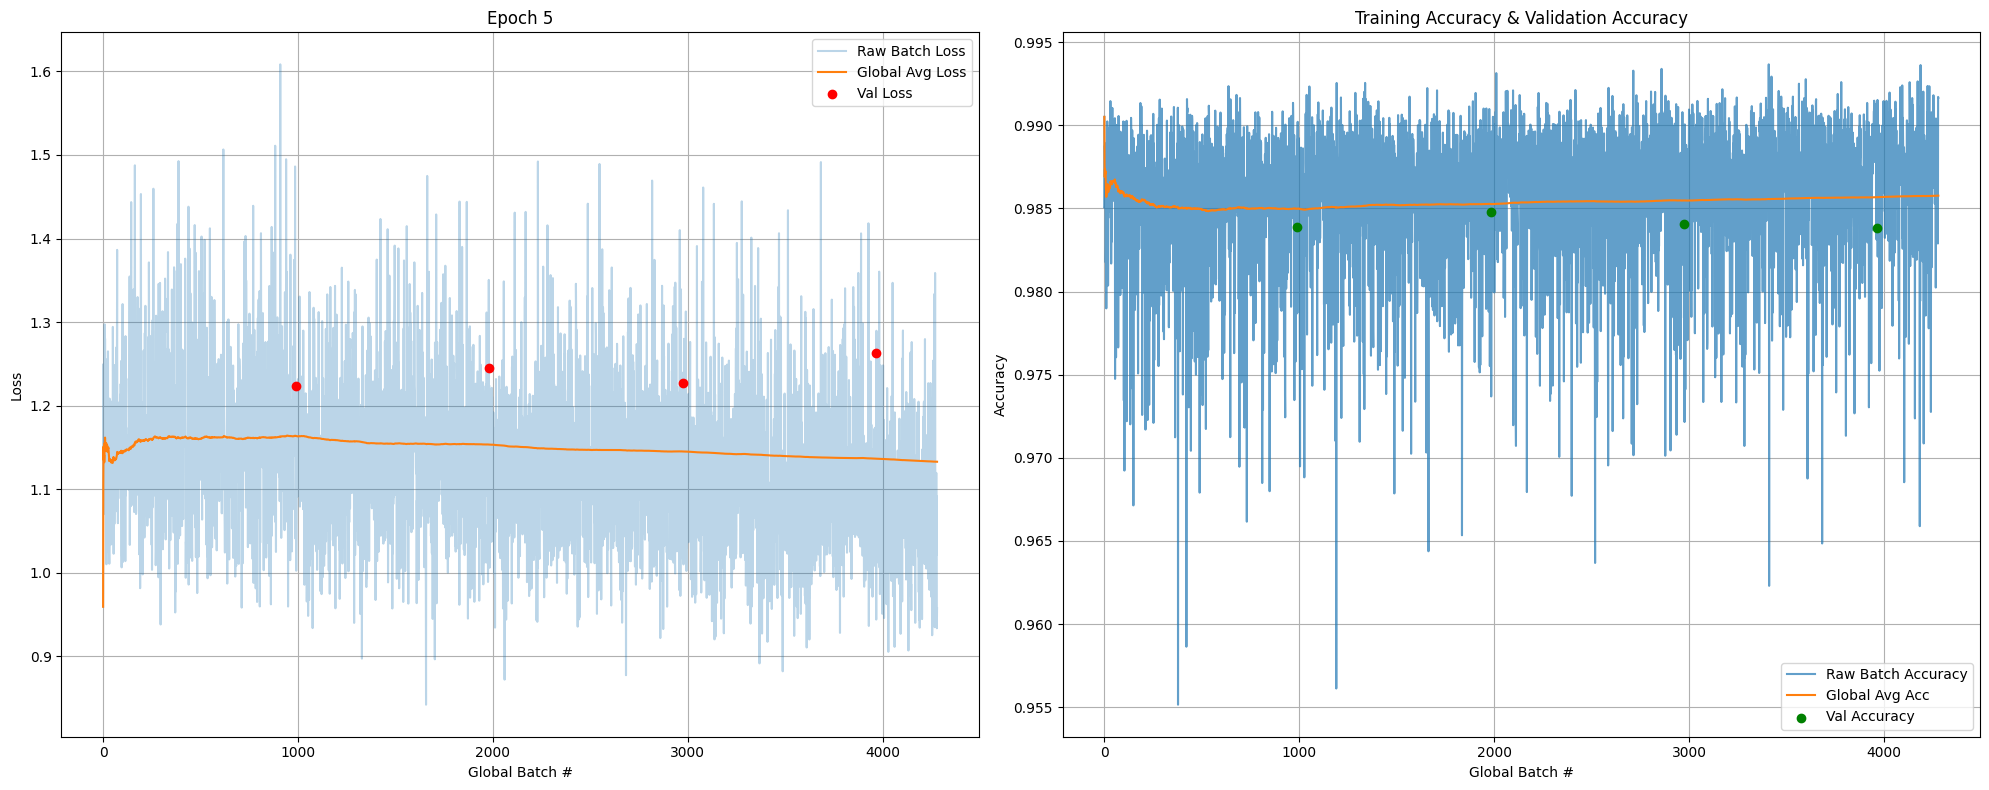

Epoch [5/15]:  32%|███▏      | 316/991 [05:48<13:48,  1.23s/it, loss=1.09]

In [ ]:
train_model(model=model, train_loader=train_loader, val_loader=val_subset_loader, optimizer=optimizer, loss_fn=loss_fn, scheduler=scheduler, num_epochs=EPOCHS, device='cuda', plot_loss=True)


### Results visualization

#### (Reference) Old model withoug boundary-aware loss and label considering void class as objects

Random Indices: [1723, 1626, 2064]


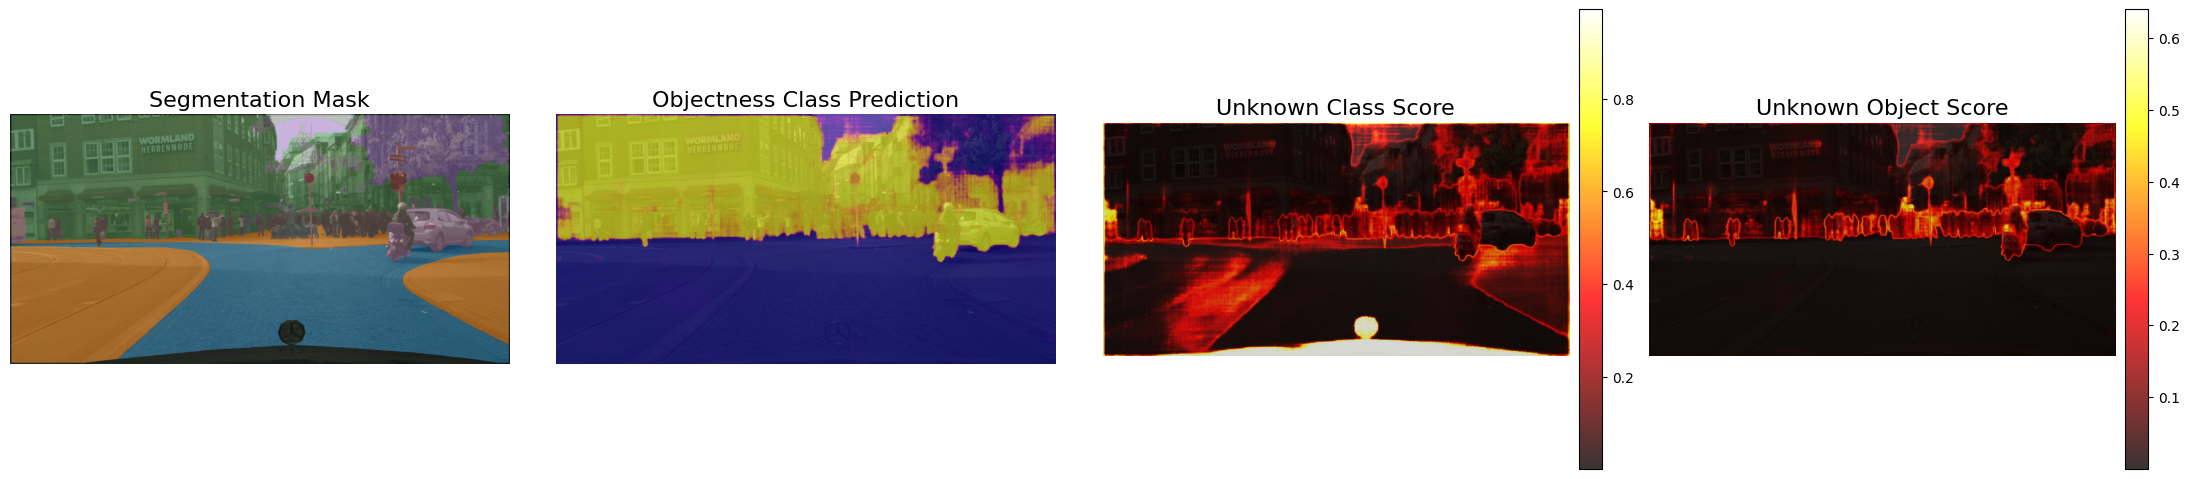

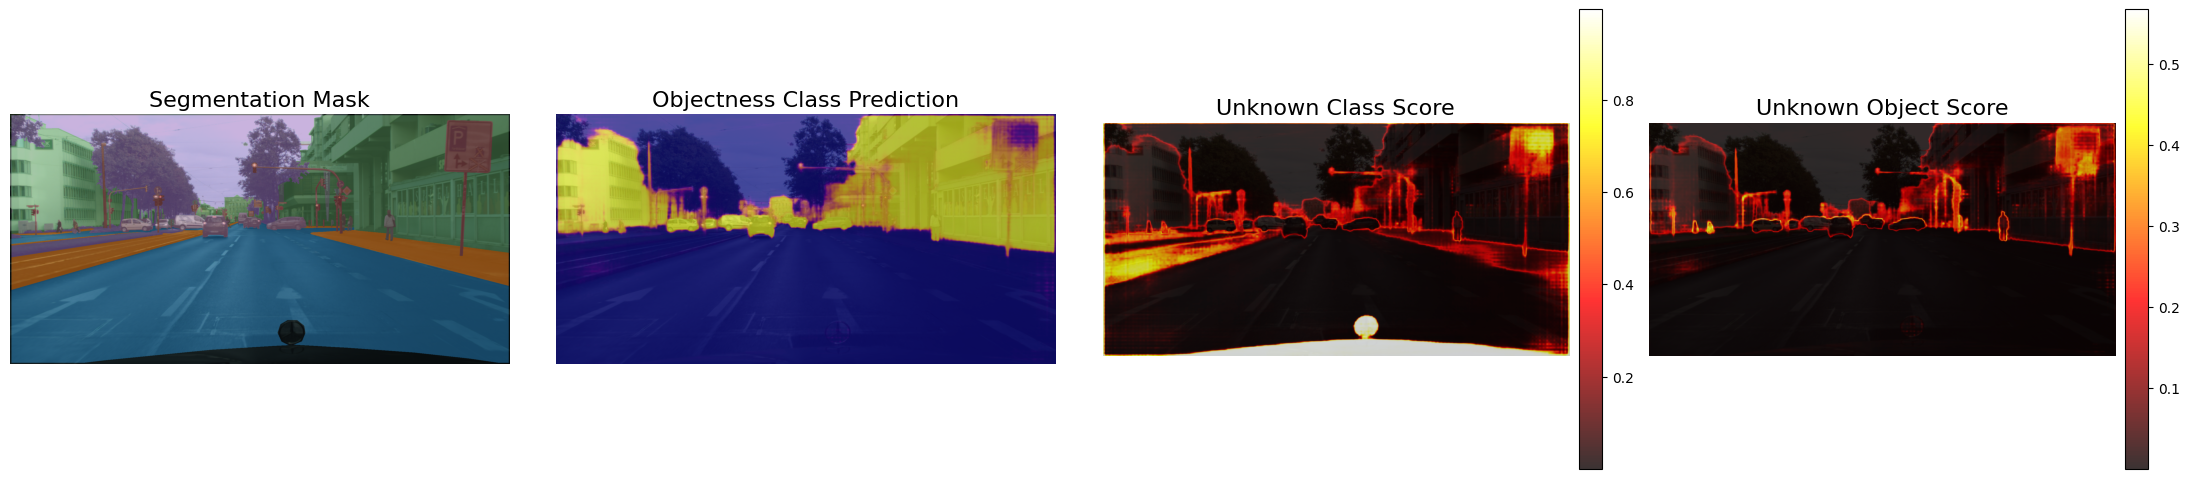

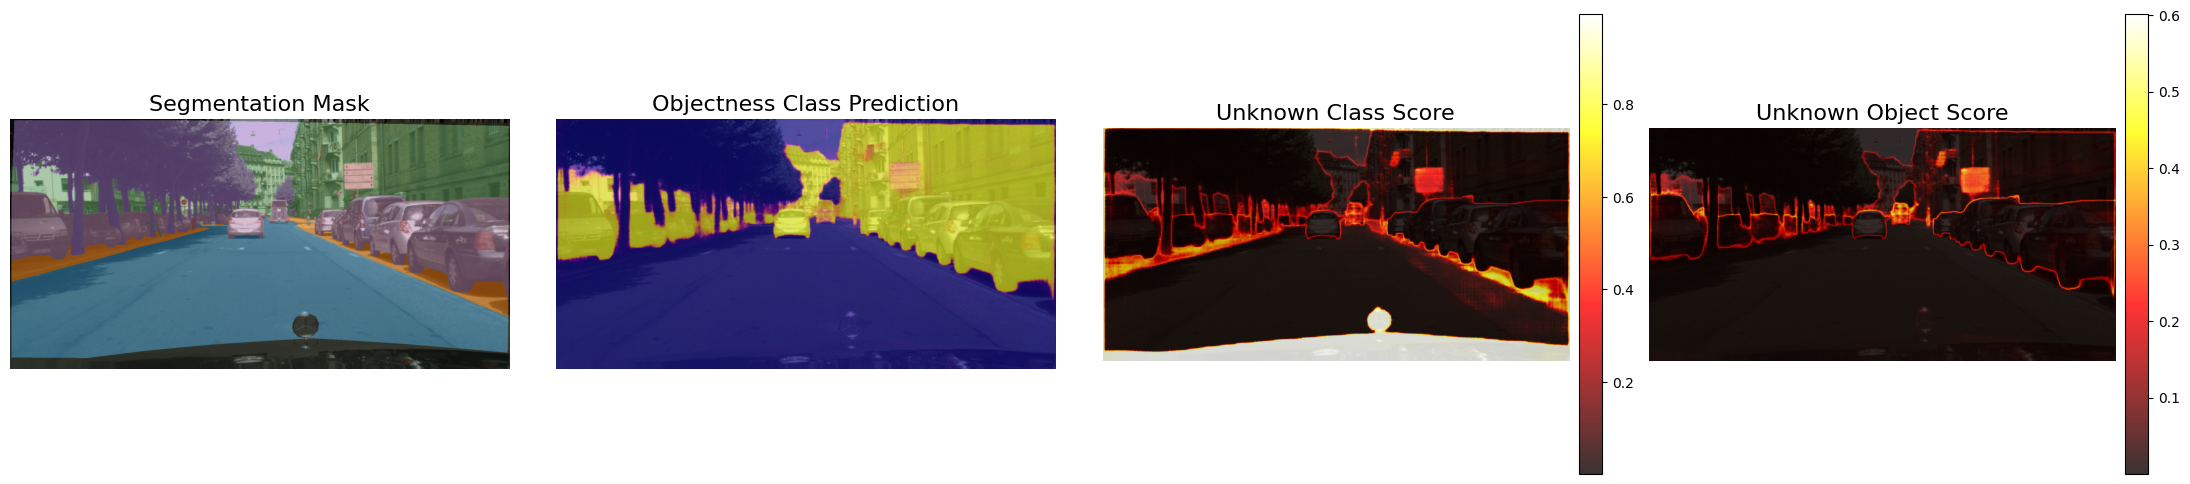

In [ ]:
# Ensure model is on same device as image
old_model = old_model.to(DEVICE)
df = train_set
indices = random.sample(range(len(df)), 3)
print(f"Random Indices: {indices}")
for idx in indices:
    image, mask = df[idx]

    mask = torch.from_numpy(np.array(mask)).float()

    image = image.to(DEVICE)

    unkown_obj_score, unknown_score, objectness_score, pred_mask = old_model.unknown_obj_scores(image, uos_only=False)

    visualize_uos(image, mask, unkown_obj_score, unknown_score, objectness_score)

#### Recently Trained Model

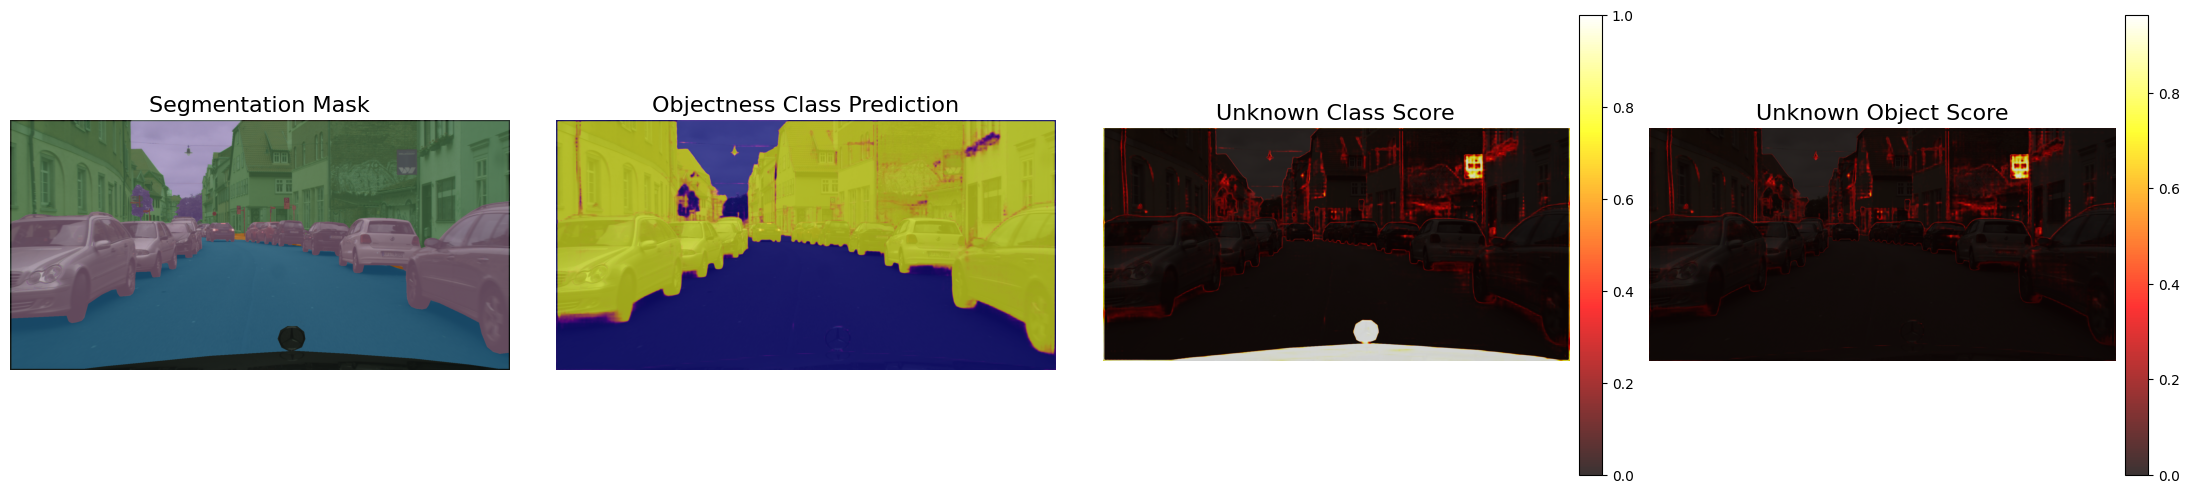

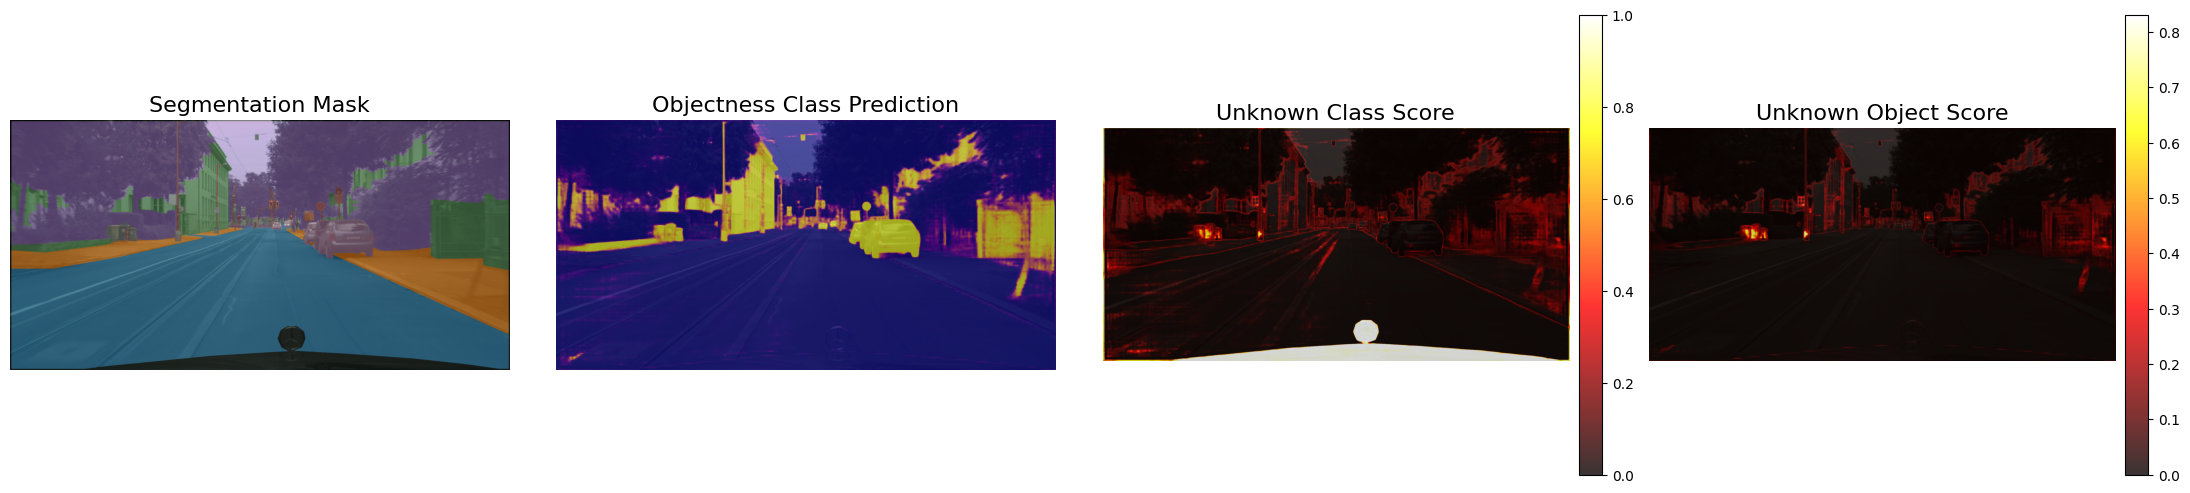

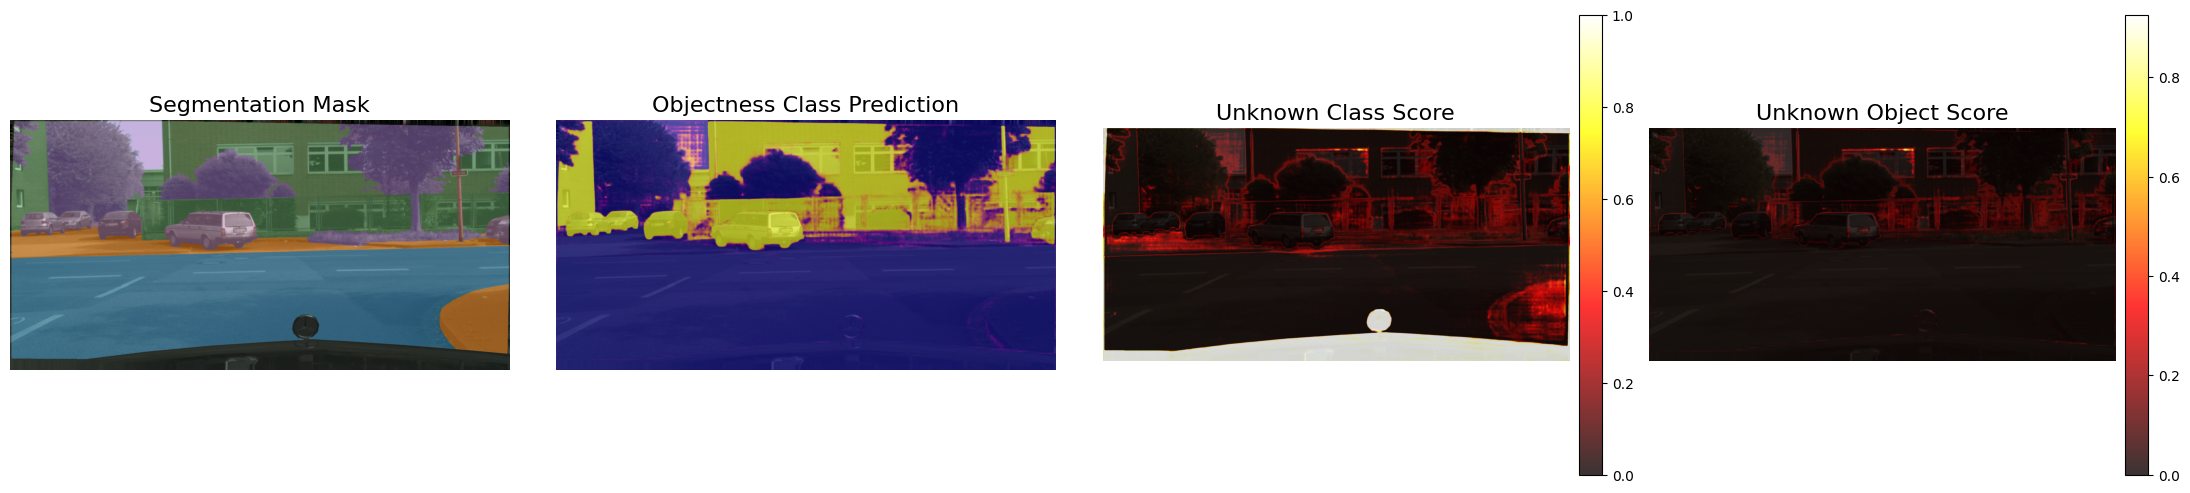

In [111]:
# Ensure model is on same device as image
model = model.to(DEVICE)
df = train_set

for idx in indices:
    image, mask = df[idx]

    mask = torch.from_numpy(np.array(mask)).float()

    image = image.to(DEVICE)

    unkown_obj_score, unknown_score, objectness_score, pred_mask = model.unknown_obj_scores(image, uos_only=False)

    visualize_uos(image, mask, unkown_obj_score, unknown_score, objectness_score)

### Inermediate model

Random Indices: [1723, 1626, 2064]


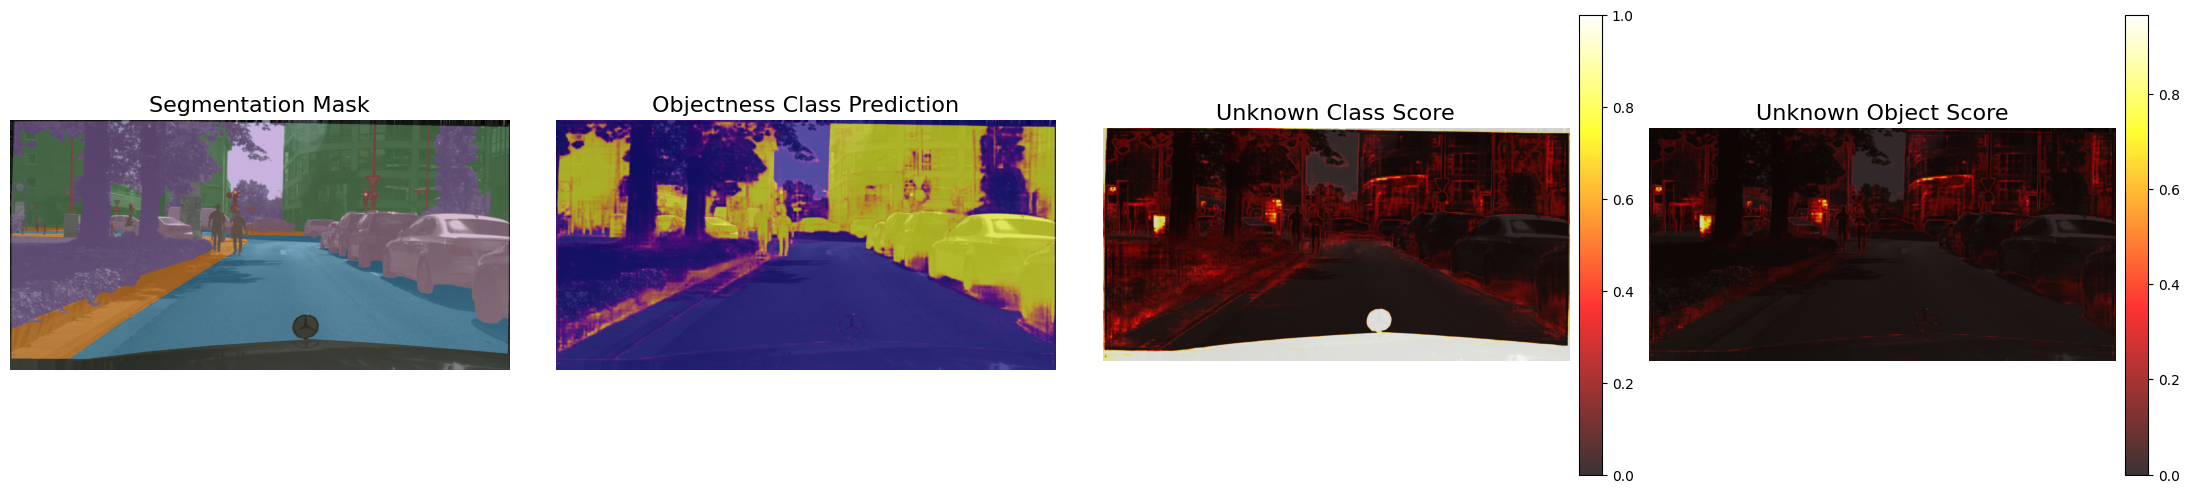

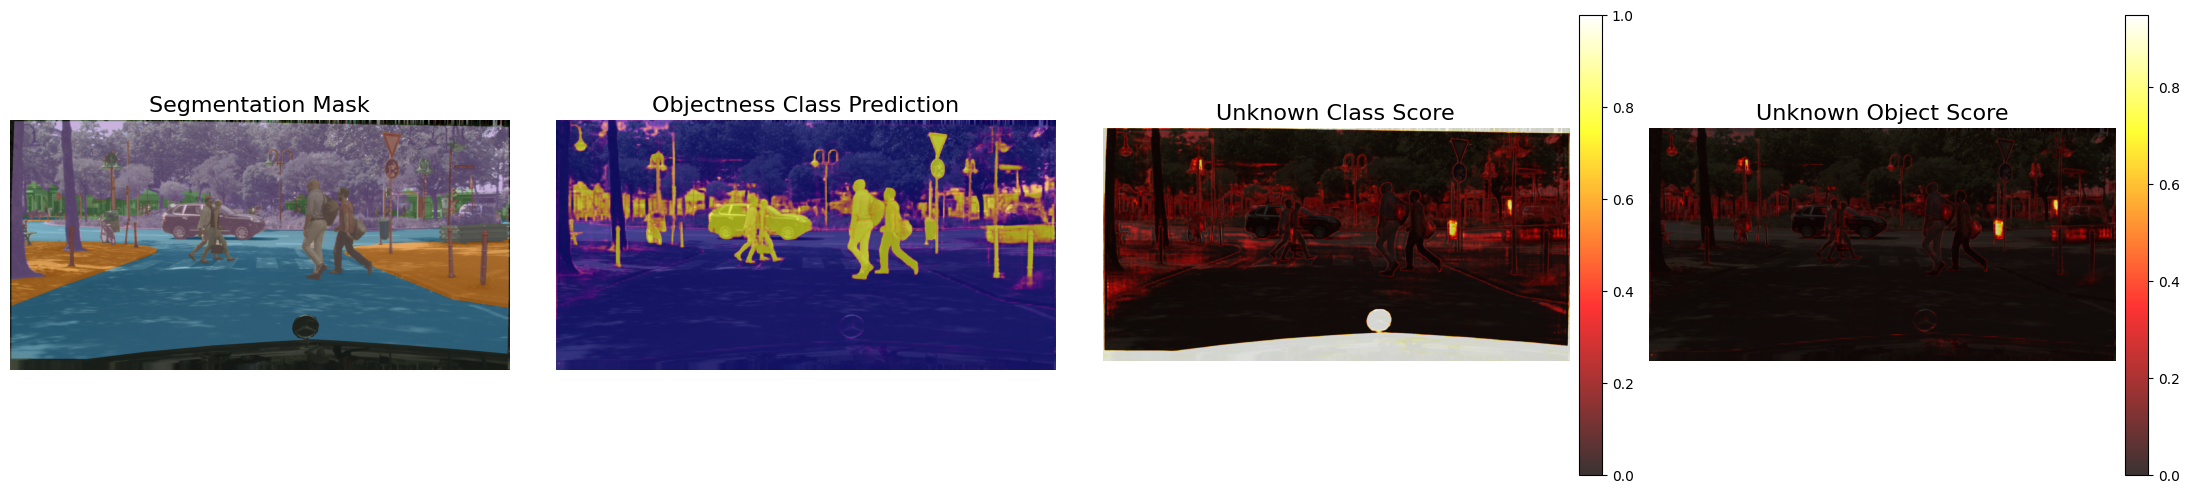

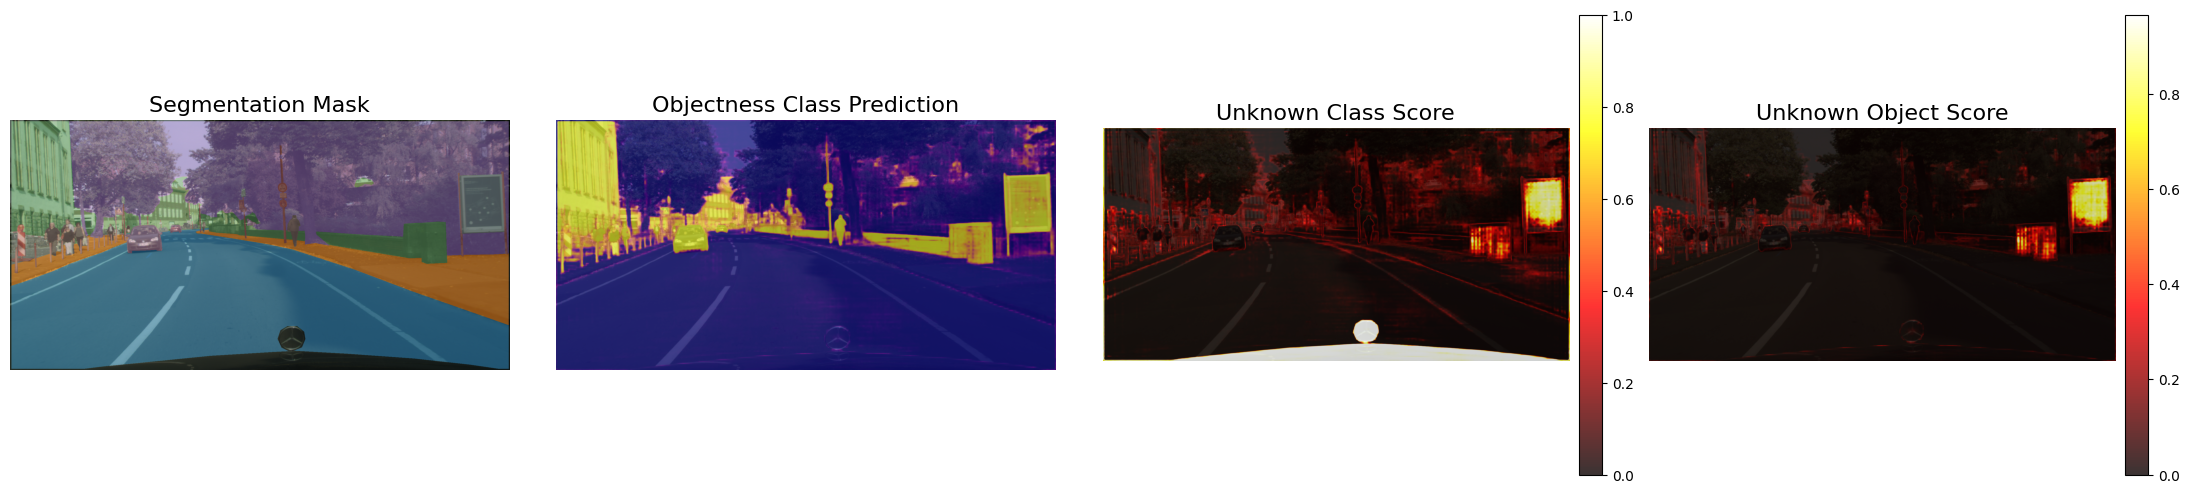

In [ ]:
# Ensure model is on same device as image
model = model.to(DEVICE)
df = val_set
print(f"Random Indices: {indices}")
indices_val = random.sample(range(len(df)), 3)
for idx in indices_val:
    image, mask = df[idx]

    mask = torch.from_numpy(np.array(mask)).float()

    image = image.to(DEVICE)

    unkown_obj_score, unknown_score, objectness_score, pred_mask = model.unknown_obj_scores(image, uos_only=False)

    visualize_uos(image, mask, unkown_obj_score, unknown_score, objectness_score)

# 7. Model Validation

In [141]:
folder_path = '/content/drive/MyDrive/model_weights'

model_weights = sorted(
    f for f in os.listdir(folder_path)
    if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.pth')
)

validation_results = {}
for ckpt_name in model_weights:
    ckpt_path = os.path.join(folder_path, ckpt_name)
    model = DeepLabV3_SigmoidHead(num_classes=7, weights_path=ckpt_path)
    model.to(DEVICE)
    # --- evaluate ---
    avg_loss, accuracy = model.evaluate_model(val_loader, device=DEVICE, loss_fn=loss_fn, training=False)
    print(f"{ckpt_name} → loss={avg_loss:.4f}, acc={accuracy:.2%}")
    validation_results[ckpt_name] = {'loss': avg_loss, 'acc': accuracy}


## First epochs validation results: Loss and Accuracy
**Non boundary-aware, no OOD data**

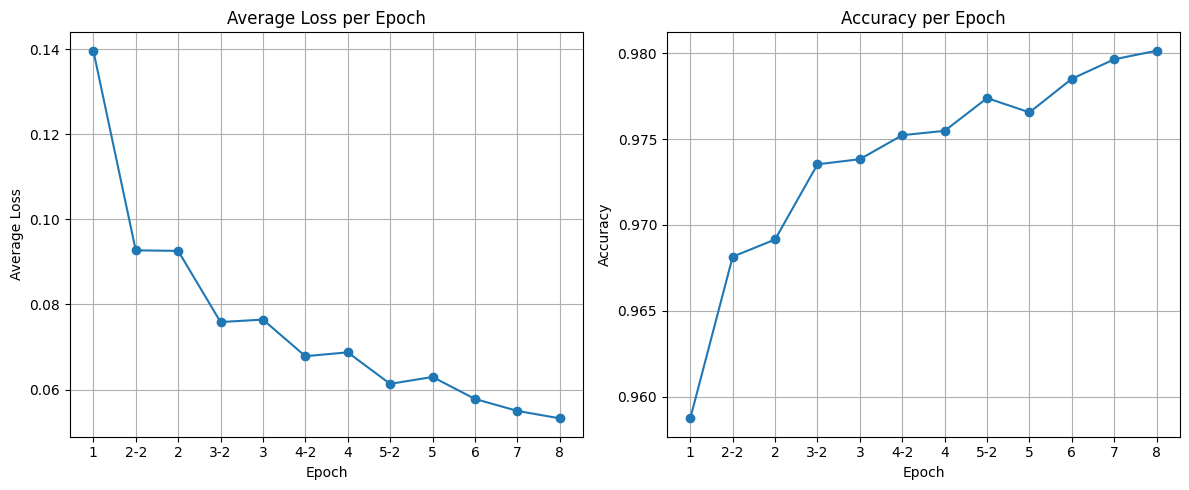

In [ ]:
plt.figure(figsize=(12, 5))
# Plot Average Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, avg_loss_list, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Average Loss per Epoch")
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy_list, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.grid(True)

plt.tight_layout()
plt.show()

## Later epochs validation results: Loss and Accuracy
**Boundary-aware training, including OOD data**

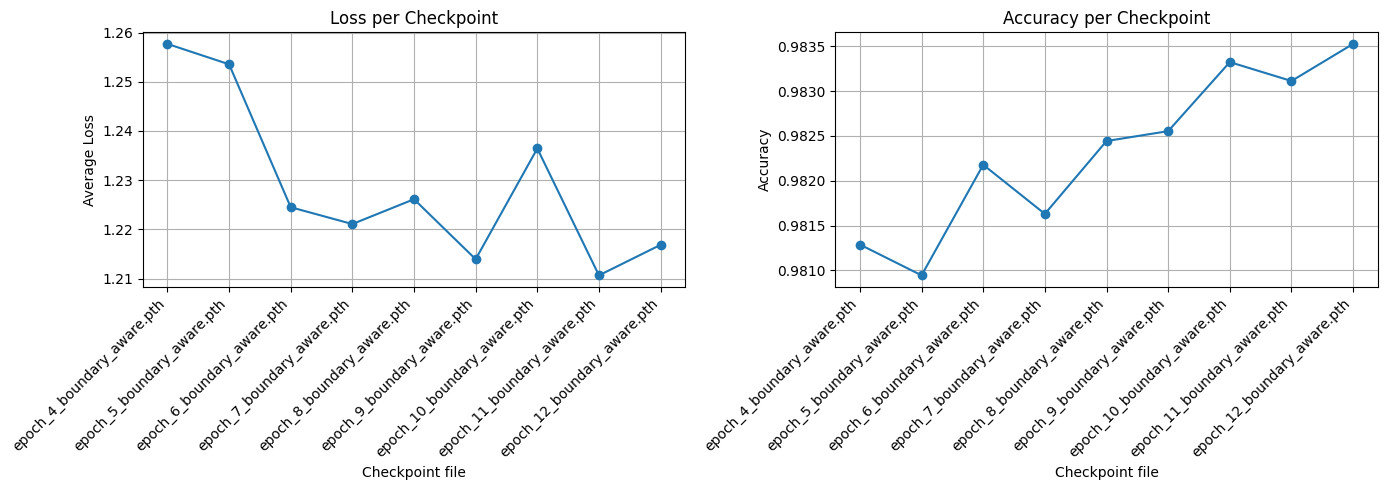

In [133]:
order = [
    'epoch_4_boundary_aware.pth','epoch_5_boundary_aware.pth', 'epoch_6_boundary_aware.pth',
    'epoch_7_boundary_aware.pth', 'epoch_8_boundary_aware.pth', 'epoch_9_boundary_aware.pth',
    'epoch_10_boundary_aware.pth', 'epoch_11_boundary_aware.pth', 'epoch_12_boundary_aware.pth'
]


losses = [validation_results[m]['loss'] for m in order]
accs   = [validation_results[m]['acc']  for m in order]
x      = list(range(len(order)))

plt.figure(figsize=(14, 5))

# --- Average Loss subplot ---
plt.subplot(1, 2, 1)
plt.plot(x, losses, marker='o', linestyle='-')
plt.xticks(x, order, rotation=45, ha='right')
plt.xlabel("Checkpoint file")
plt.ylabel("Average Loss")
plt.title("Loss per Checkpoint")
plt.grid(True)

# --- Accuracy subplot ---
plt.subplot(1, 2, 2)
plt.plot(x, accs, marker='o', linestyle='-')
plt.xticks(x, order, rotation=45, ha='right')
plt.xlabel("Checkpoint file")
plt.ylabel("Accuracy")
plt.title("Accuracy per Checkpoint")
plt.grid(True)

plt.tight_layout()
plt.show()